# ML 2-class Classification with RFC Model

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f29143ccb50>

MLfit applied to 4FGL-DR4 

Scikit-learn specifications: 
* features: log_var, log_fpeak, log_epeak, sqrt_d
* classes: pulsar, blazar
* model: RandomForestClassifier(max_features=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2941726ef0>
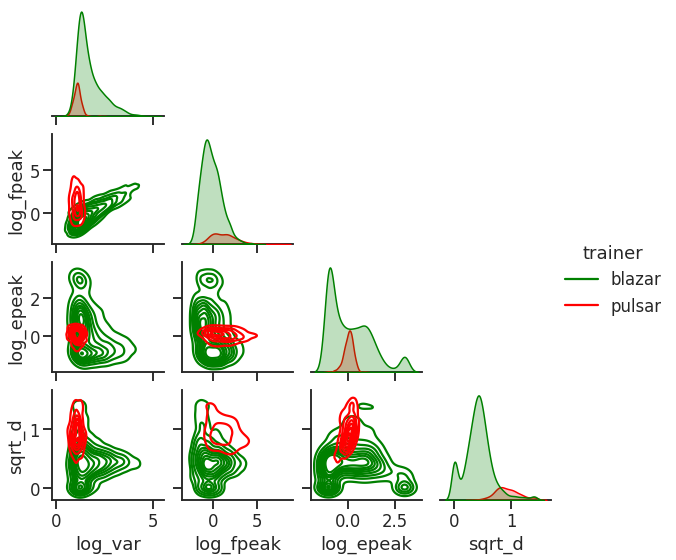

Expand the important pairs

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f29409315a0>
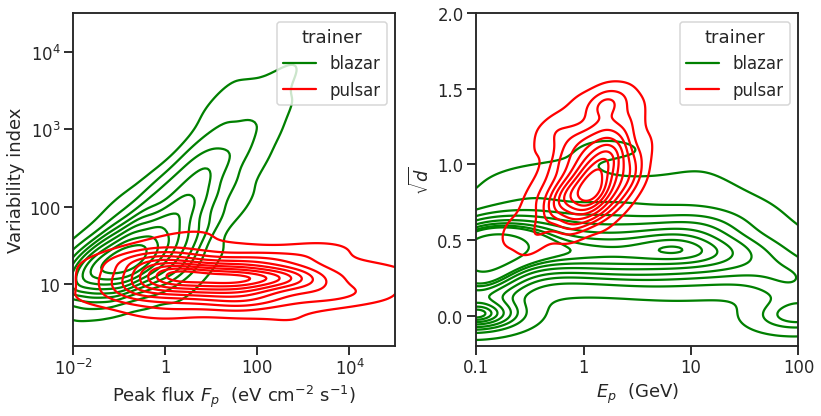

## Train then apply prediction, add probs 

### Accuraccy for pulsar/blazar separation
A standard classification performance metric, the accuracy  "ROC-AUC", is described in 
Luo at al.

With our model "RandomForestClassifier" we obtain (99.25$\pm$ 0.05)%

Compare this with 
     [Luo et al (2020)](https://academic.oup.com/mnras/article/492/4/5377/5709930), who achieved 
     (99.17$\pm$ 0.17)% with three features, also with Random Forest.

### All predictions

prediction,blazar,pulsar
class_group,,
blazar,2283,0
pulsar,0,316
galaxy,85,3
Galactic,95,128
unID,2995,908


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f294173b430>
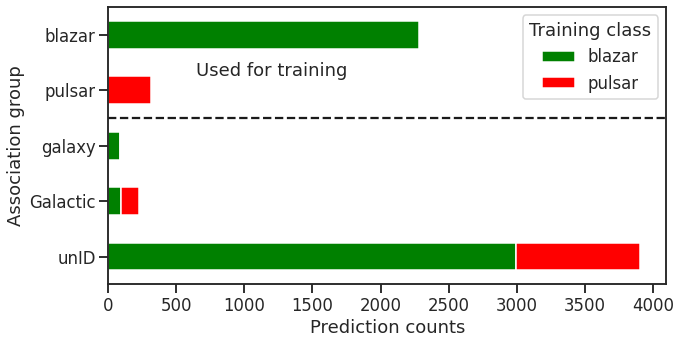

## The issue with this
In figure 1.4, we show plots of the pulsar probability vs.  $E_p$ for the training classes, in 
 the upper panel and for the unID in the lower, wich colors corresponding to the class prediction.

The large number of unID sources with intermediate probabilites is inconsistent with
 a mixture of the two classes. 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2940d69390>
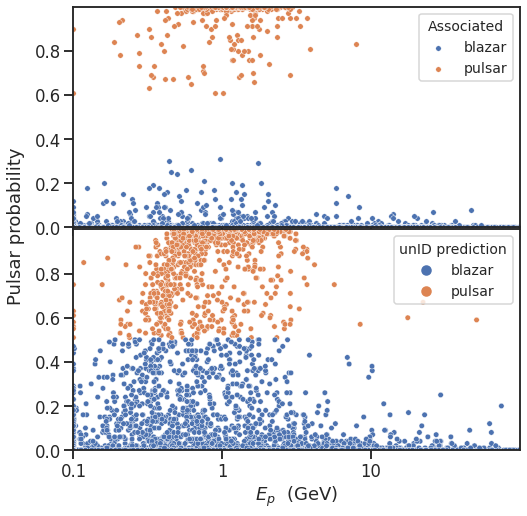

File `files/dr4_2_class_classification.csv` exists--not overwriting.


In [5]:
%reset -f
%run pylib/ml_fit paper doc

### Pulsar probability vs $d$ 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2940930ca0>
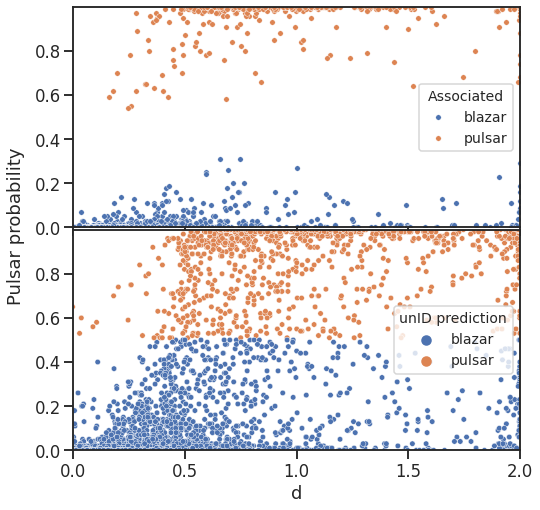

In [4]:
show(f"""### Pulsar probability vs $d$ """)  
show_fig(self.psrprob_vs_d, 'd');

In [3]:
self.write_summary(True)

* Load diffuse file,  `/mnt/c/users/thbur/OneDrive/fermi/diffuse/gll_iem_v07_hpx.fits`
  unit=$\rm{eV\ cm^{-2}\ s^{-1}\ deg^{-2}}$
 select energy= 1000 MeV
Wrote 6813-record summary, using model RandomForestClassifier(max_features=2), to `files/dr4_2_class_classification.csv` 
  columns: ['source_type', 'glat', 'glon', 'significance', 'class1', 'association', 'flags', 'r95', 'trainer', 'Ep', 'Fp', 'd', 'diffuse', 'p_pulsar']
